# txt2img

In [1]:
from IPython.display import Markdown, display

In [2]:
#@title Installation
!git clone https://github.com/CompVis/taming-transformers
!git clone https://github.com/jtc42/latent-diffusion-mps.git latent-diffusion

%pip install -r ./latent-diffusion/requirements.txt
%pip install -e ./latent-diffusion
%pip install -e ./taming-transformers

fatal: destination path 'taming-transformers' already exists and is not an empty directory.
fatal: destination path 'latent-diffusion' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cpu
Note: you may need to restart the kernel to use updated packages.
Obtaining file:///Users/joel/Source/latent-diffusion-mps/scripts/latent-diffusion
  Preparing metadata (setup.py) ... done
  Attempting uninstall: latent-diffusion
    Found existing installation: latent-diffusion 0.0.1
    Uninstalling latent-diffusion-0.0.1:
      Successfully uninstalled latent-diffusion-0.0.1
  Running setup.py develop for latent-diffusion
Note: you may need to restart the kernel to use updated packages.
Obtaining file:///Users/joel/Source/latent-diffusion-mps/scripts/taming-transformers
  Preparing metadata (setup.py) ... done
  Attempting uninstall: taming-transformers
    Found existing installation: taming-transformers 0.0.1
    U

In [3]:
#@title Setup
import sys
sys.path.append('../taming-transformers')
from taming.models import vqgan

/Users/joel/Source/latent-diffusion-mps/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#@title Download models
import os

if not os.path.exists("./models/ldm/text2img-large/model.ckpt"):
  !mkdir -p ./models/ldm/text2img-large/
  !wget -O ./models/ldm/text2img-large/model.ckpt https://ommer-lab.com/files/latent-diffusion/nitro/txt2img-f8-large/model.ckpt

In [5]:
#@title Loading utils
import torch
from omegaconf import OmegaConf

from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddpm import LatentDiffusion


def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    sd = pl_sd["state_dict"]
    model: LatentDiffusion = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)

    if len(m) > 0:
        print("missing keys:")
        print(m)
    if len(u) > 0:
        print("unexpected keys:")
        print(u)

    model.to(device="mps", dtype=torch.float32)
    model.eval()

    return model


def get_model() -> LatentDiffusion:
    config = OmegaConf.load("./latent-diffusion/configs/latent-diffusion/txt2img-1p4B-eval.yaml")  
    model = load_model_from_config(config, "./models/ldm/text2img-large/model.ckpt")

    return model

In [6]:
#@title Load the model

model: LatentDiffusion = get_model()

Loading model from ./models/ldm/text2img-large/model.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 872.30 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
unexpected keys:
['model_ema.decay', 'model_ema.num_updates']


In [9]:
#@title Generate images

import numpy as np 
from PIL import Image
from einops import rearrange

from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler

%env TOKENIZERS_PARALLELISM=false

plms = True

prompt = "painting of a hamster drinking coffee"

ddim_steps = 50
ddim_eta = 0.0
n_samples = 3
n_iter = 3
scale = 10.0  # default: 5.0

height = 256
width = 256

all_samples = list()

if plms:
    sampler = PLMSSampler(model)
else:
    sampler = DDIMSampler(model)

with torch.no_grad():
    with model.ema_scope():
        uc = None
        if scale != 1.0:
            uc = model.get_learned_conditioning(n_samples * [""])
        
        for n in range(n_iter):
            print(f"Sample {n}")
            c = model.get_learned_conditioning(n_samples * [prompt])
            shape = [4, height // 8, width// 8]
            
            samples_ddim, _ = sampler.sample(S=ddim_steps,
                                             conditioning=c,
                                             batch_size=n_samples,
                                             shape=shape,
                                             verbose=False,
                                             unconditional_guidance_scale=scale,
                                             unconditional_conditioning=uc, 
                                             eta=ddim_eta)

            x_samples_ddim = model.decode_first_stage(samples_ddim)
            x_samples_ddim = torch.clamp(
                (x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0
            )

            for x_sample in x_samples_ddim:
                x_sample = 255.0 * rearrange(
                    x_sample.cpu().numpy(), "c h w -> h w c"
                )
            
            all_samples.append(x_samples_ddim)

env: TOKENIZERS_PARALLELISM=false
Sample 0
Data shape for PLMS sampling is (3, 4, 32, 32)
Running PLMS Sampling with 50 timesteps


PLMS Sampler: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]


Sample 1
Data shape for PLMS sampling is (3, 4, 32, 32)
Running PLMS Sampling with 50 timesteps


PLMS Sampler: 100%|██████████| 50/50 [00:39<00:00,  1.27it/s]


Sample 2
Data shape for PLMS sampling is (3, 4, 32, 32)
Running PLMS Sampling with 50 timesteps


PLMS Sampler: 100%|██████████| 50/50 [00:36<00:00,  1.36it/s]


## painting of a hamster drinking coffee

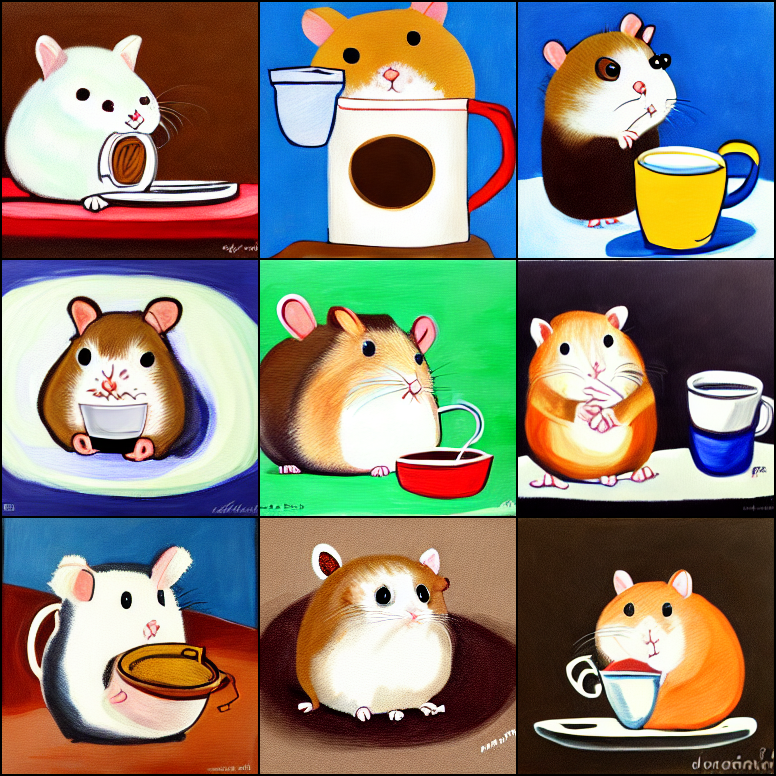

In [10]:
#@title Display images

from torchvision.utils import make_grid

grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w').cpu()
grid = make_grid(grid, nrow=n_samples)

grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()

img = Image.fromarray(grid.astype(np.uint8))

display(Markdown(f"## {prompt}"))
display(img)